In [1]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np
import math

import torch
import torch.nn.functional as F

import random

from PIL import Image

from network import U_Net

from torchvision import transforms

from utils import merge_masks, dense_crf
from utils import plot_img_and_mask

In [2]:
PATH = os.path.abspath('.')

SOURCE_IMAGES = [os.path.join(PATH, "../data/images/2018-11-30-12-58-17_sunny")]

images = []

for si in SOURCE_IMAGES:
    images.extend(glob(os.path.join(si, "*.png")))
    
print("Datasets used: {}\n".format(SOURCE_IMAGES))

images.sort()

Datasets used: ['/home/kenny/Desktop/lanes-segmentation/torch/../data/images/2018-11-30-12-58-17_sunny']



In [3]:
print(np.size(images))

1286


In [4]:
def crop(x, crop_h=320, crop_w=1152):
    h,w = x.shape[:2]
    h_new = h-crop_h, h
    w_new = int(math.floor((w-crop_w)/2.)), int(math.floor(w-(w-crop_w)/2.))
    return x[h_new[0]:h_new[1], w_new[0]:w_new[1], :]

def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

def normalize(x):
    return np.float32(x/255.)

In [5]:
def get_image(path):
    
    image = Image.open(path)
    image = image.resize((1152,int(1152/2.5)))
        
    return(np.asarray(image))

(320, 1152, 3)
uint8


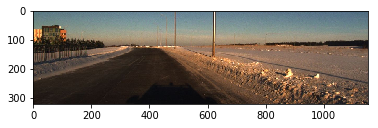

In [12]:
img = crop(get_image(images[0]))

print(img.shape)
print(img.dtype)

plt.imshow(img)

In [ ]:
# images = images[:25]
images = images[175:185]

In [13]:
x_test = []

for i in images:
    x_test.append(crop(get_image(i)))

x_test = np.asarray(x_test)

In [14]:
x_test.shape

(10, 320, 1152, 3)

In [15]:
net = U_Net(img_ch=3, output_ch=1)

if torch.cuda.is_available():
    gpu = True
else:
    gpu = False

weights = "checkpoints/CP99.pth"

if gpu:
    net.load_state_dict(torch.load(weights))
    net.cuda() 

else:
    net.load_state_dict(torch.load(weights, map_location='cpu'))
    net.cpu()
    
net.eval()

U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (Conv3): conv

In [16]:
y_pred = np.zeros([len(images), 320, 1152], dtype=np.float32)

for i,im in enumerate(images):

    with torch.no_grad():
        
        img = get_image(im)
        img = crop(img)
        img = hwc_to_chw(img)
        img = normalize(img)
        
        X = torch.from_numpy(img).unsqueeze(0)

        if gpu:
            X = X.cuda()

        y_pred[i] = net(X)
        
        print("Predicted {}".format(i))

Predicted 0
Predicted 1
Predicted 2
Predicted 3
Predicted 4
Predicted 5
Predicted 6
Predicted 7
Predicted 8
Predicted 9


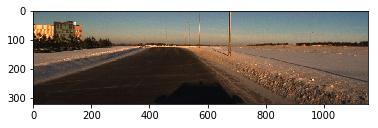

In [29]:
plt.imshow(crop(get_image(images[8])))

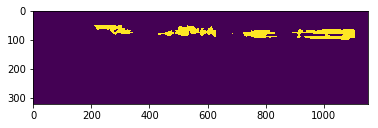

In [28]:
plt.imshow(y_pred[8])

In [19]:
y_pred = y_pred > 0.5

In [ ]:
import webcolors

def colorize(mask):
    hex_colors = ['#000000', '#50E3C2']

    rgb_colors = []

    for hex_color in hex_colors:
        rgb_colors.append(webcolors.hex_to_rgb(hex_color))
        
    colors = np.array(rgb_colors)
        
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

In [ ]:
n = 0

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15,10)
axes[0].imshow(get_image(images_test[n]))
axes[1].imshow(colorize(get_image(labels_test[n])))
axes[2].imshow(colorize(np.array(y_pred[n], dtype=np.int32)))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15,10)
for i in range(len(x_test)):
    axes[0].set_title('RGB Image')
    axes[1].set_title('GT Mask')
    axes[2].set_title('Prediction Mask')
    axes[0].imshow(get_image(images_test[i]))
    axes[1].imshow(colorize(get_image(labels_test[i])))
    axes[2].imshow(colorize(np.array(y_pred[i], dtype=np.int32)))
    fig.tight_layout()
    fig.savefig('results/egolane/U_Net/img{}.png'.format(i))